### Prüfen und installieren der benötigten Pakete

In [1]:
if (!require("stringdist")) {
   install.packages("stringdist", repos="https://cran.uni-muenster.de/")
   library(stringdist)
   }

if (!require("plotly")) {
   install.packages("plotly", repos="https://cran.uni-muenster.de/")
   library(plotly)
   }

if (!require("RColorBrewer")) {
   install.packages("RColorBrewer", repos="https://cran.uni-muenster.de/")
   library(RColorBrewer)
   }

if (!require("gplots")) {
   install.packages("gplots", dependencies = TRUE,repos="https://cran.uni-muenster.de")
   library(gplots)
   }

if (!require("tm")) {
   install.packages("tm", dependencies = TRUE,repos="https://cran.uni-muenster.de")
   library(tm)
   }

if (!require("SnowballC")) {
   install.packages("SnowballC", dependencies = TRUE,repos="https://cran.uni-muenster.de")
   library(SnowballC)
   }

library(reshape2)
library(dplyr)

Loading required package: stringdist
Loading required package: plotly
Loading required package: ggplot2

Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: RColorBrewer
Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Loading required package: tm
Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate

Loading required package: SnowballC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



## Laden der Daten

In [3]:
AnforderungenDB <- read.csv("skillsDB.csv", sep=";")

In [4]:
KenntnisseDB <- read.csv("skills.csv", sep=";")

### Untersuchen der Daten

In [5]:
dim(AnforderungenDB)

[1] 47  2

In [6]:
dim(KenntnisseDB)

[1] 154   1

AnforderungenDB ist eine Liste von Anforderungen (z.B. für eine zu besetzende Stelle), gegen die wir die Kenntnisse matchen.

In [7]:
head(AnforderungenDB)

Skill,Kategorie
V-Modell,Entwicklungsmethoden
Wasserfallmodell,Entwicklungsmethoden
Spiralmodell,Entwicklungsmethoden
Agile Modelle,Entwicklungsmethoden
Scrum,Entwicklungsmethoden
test-driven development,Entwicklungsmethoden


KenntnisseDB ist eine Liste von Kenntnissen (z.B. aus dem CV eines Bewerbers), die wir gegen unsere Anforderungen matchen. Die Kenntnisse enthalten unterschiedliche Schreibweisen und Rechtschreibfehler.

In [8]:
head(KenntnisseDB)

Skill
V-Modell
Entwicklung nach V-Modell
VModell
V-Model
Wasserfallmodell
waterfall model


Zufälliges Ziehen von 20 Zeilen aus KenntnisseDB, um ein Kandidatenprofil aus 20 Skills zu simulieren

In [9]:
Kandidat <-KenntnisseDB[sample(nrow(KenntnisseDB),20, replace=F),]
Kandidat

[1] LabVIEW Programmieren       Visual basic Programmierung
 [3] Entwicklung in C            Java-Programmierung        
 [5] desing                      Ilmplementierung           
 [7] Javaentwicklung             test-driven development    
 [9] MS-Access                   mySQL                      
[11] ABAP-Development            SAP-CRM                    
[13] Datawarehousing             Design                     
[15] Analyse                     Programmieren in C++       
[17] Programmieren in Perl       V-Modell                   
[19] Aufbau mySQL-Datenbank      Javacsript                 
154 Levels: ABAP ABAP-Development ABAP Entwicklung ... waterfall model

Zufälliges Ziehen von 10 Zeilen aus AnforderungenDB, um ein Stellenprofil aus 10 Skills zu simulieren

In [10]:
Anforderungen <- AnforderungenDB[sample(nrow(AnforderungenDB), 10, replace=F),]
Anforderungen

,Skill,Kategorie
23,ABAP,Programmiersprachen
26,MS-SQL Server,Datenbanken
29,PostgreSQL,Datenbanken
28,MS-Access,Datenbanken
35,SAP CRM,Business IT
37,Modulbetreuung,Business IT
5,Scrum,Entwicklungsmethoden
3,Spiralmodell,Entwicklungsmethoden
24,VHDL,Programmiersprachen
30,SQL,Datenbanken


## Preprocessing

Um die Berechnung der Ähnlichkeit zu vereinfachen werden zunächst die Strings zu lowercase transformiert.

In [11]:
Anforderungen$Skill <- sapply(Anforderungen$Skill, tolower)
Anforderungen

,Skill,Kategorie
23,abap,Programmiersprachen
26,ms-sql server,Datenbanken
29,postgresql,Datenbanken
28,ms-access,Datenbanken
35,sap crm,Business IT
37,modulbetreuung,Business IT
5,scrum,Entwicklungsmethoden
3,spiralmodell,Entwicklungsmethoden
24,vhdl,Programmiersprachen
30,sql,Datenbanken


In [12]:
Kandidat <- tolower(Kandidat)
Kandidat

[1] "labview programmieren"       "visual basic programmierung"
 [3] "entwicklung in c"            "java-programmierung"        
 [5] "desing"                      "ilmplementierung"           
 [7] "javaentwicklung"             "test-driven development"    
 [9] "ms-access"                   "mysql"                      
[11] "abap-development"            "sap-crm"                    
[13] "datawarehousing"             "design"                     
[15] "analyse"                     "programmieren in c++"       
[17] "programmieren in perl"       "v-modell"                   
[19] "aufbau mysql-datenbank"      "javacsript"

Dann werden "-" durch Leerzeichen ersetzt.

In [13]:
Anforderungen$Skill <- gsub("-", " ", Anforderungen$Skill)

In [37]:
Kandidat <- gsub("-", " ", Kandidat)

Um die Funktionen der Bibliothek "tm" nutzen zu können, müssen die Datensätze transformiert werden:

In [15]:
corpus_anf <- VCorpus(VectorSource(Anforderungen$Skill))
corpus_kand <- VCorpus(VectorSource(Kandidat))

Dann wird stemming und stopword removal durchgeführt

In [16]:
corpus_anf <- tm_map(corpus_anf, removeWords, stopwords("german"))
corpus_kand <- tm_map(corpus_kand, removeWords, stopwords("german"))

In [23]:
corpus_anf <- tm_map(corpus_anf, stemDocument, language="german")
corpus_kand <- tm_map(corpus_kand, stemDocument, language="german")

Jetzt werden die Datensätze zurück transformiert.

In [24]:
anf_data <- data.frame(lapply(corpus_anf, as.character))
kand_data <- data.frame(lapply(corpus_kand, as.character))

In [25]:
anf_data <- t(anf_data)
kand_data <- t(kand_data)

In [26]:
anf_data

X1,abap
X2,ms sql serv
X3,postgresql
X4,ms access
X5,sap crm
X6,modulbetreu
X7,scrum
X8,spiralmodel
X9,vhdl
X10,sql


In [27]:
kand_data

X1,labview programmi
X2,visual basic programmier
X3,entwickl c
X4,java-programmier
X5,des
X6,ilmplementier
X7,javaentwickl
X8,test-driv develop
X9,ms-access
X10,mysql
X11,abap-develop


In [32]:
rownames(anf_data)<- rownames(Anforderungen)
colnames(anf_data) <- "Skill"
rownames(kand_data)<- rownames(Kandidat)
colnames(kand_data) <- "Skill"

In [33]:
kand_data

Skill
labview programmi
visual basic programmier
entwickl c
java-programmier
des
ilmplementier
javaentwickl
test-driv develop
ms-access
mysql


Die verarbeiteten Anforderungen werden mit den Originaldaten gejoint

In [35]:
Anforderungen$Skill <- anf_data

In [36]:
Anforderungen

,Skill,Kategorie
23,abap,Programmiersprachen
26,ms sql serv,Datenbanken
29,postgresql,Datenbanken
28,ms access,Datenbanken
35,sap crm,Business IT
37,modulbetreu,Business IT
5,scrum,Entwicklungsmethoden
3,spiralmodel,Entwicklungsmethoden
24,vhdl,Programmiersprachen
30,sql,Datenbanken


In [52]:
Kandidat <- kand_data

## Matching

### Berechnung der String Distances

Um festzustellen, wie ähnlich sich Kenntnisse und Anforderungen sind, werden sie kreuzweise verglichen. Also Distanzmaß wurde "Jaro-Winkler" gewählt. Je geringer der Wert, desto ähnlicher sind sich die beiden Strings.

In [53]:
similarity_matrix <- data.frame(stringdistmatrix(Anforderungen$Skill,
                                                 Kandidat,
                                                 method = c("jw"),
                                                 p=0.25,
                                                 q=2,
                                                 useNames="strings",
                                                useBytes = TRUE))

Die Ähnlichkeitsmatrix:

In [54]:
similarity_matrix

,labview.programmi,visual.basic.programmier,entwickl..c,java.programmier,des,ilmplementier,javaentwickl,test.driv.develop,ms.access,mysql,abap.develop,sap.crm,datawareh,design,anali,programmi..c..,programmi..perl,v.model,aufbau.mysql.datenbank,javacsript
abap,0.3578431,0.2777778,1.0000000,0.3541667,1.0000000,0.5576923,0.4444444,1.0000000,0.54629630,1.0000000,0.0000000,0.40476190,0.4259259,1.0000000,0.2750000,0.6190476,0.6222222,1.0000000,0.2784091,0.4333333
ms sql serv,0.5504456,0.5239899,0.5454545,0.7310606,0.5252525,0.5262238,0.6085859,0.5837790,0.19831650,0.2090909,0.6590909,0.51082251,0.6986532,0.5808081,0.5696970,0.6709957,0.6232323,0.5440115,0.4772727,0.5393939
postgresql,0.6189542,0.5611111,0.5393939,0.5750000,0.5222222,0.6008547,0.5944444,0.5352941,0.45555556,0.5666667,0.4833333,0.53492063,0.4555556,0.4888889,1.0000000,0.4223214,0.3125000,0.4238095,0.5977273,0.5333333
ms access,0.6633987,0.5453704,0.5993266,0.6087963,0.5185185,0.5413105,0.5833333,0.6633987,0.03703704,0.3444444,0.5370370,0.41269841,0.5185185,0.5740741,0.5629630,0.5952381,0.6000000,0.4973545,0.5390572,0.6222222
sap crm,0.4810924,0.3809524,0.5887446,0.3928571,0.5079365,0.6868132,0.5158730,0.5760971,0.41269841,0.5523810,0.5158730,0.02380952,0.4973545,0.5634921,0.5523810,0.4761905,0.4841270,1.0000000,0.5822511,0.4238095
modulbetreu,0.4670232,0.4898990,0.6060606,0.6243687,0.5252525,0.4698912,0.5505051,0.4837790,0.39898990,0.3545455,0.5095960,0.58874459,0.5757576,0.5808081,0.5696970,0.6709957,0.6232323,0.3437229,0.4913420,0.7060606
scrum,0.5803922,0.5361111,0.5696970,0.4916667,1.0000000,0.5743590,1.0000000,0.4941176,0.45925926,1.0000000,1.0000000,0.32857143,1.0000000,0.5444444,1.0000000,0.4857143,0.4888889,0.5523810,0.5878788,0.4666667
spiralmodel,0.4839572,0.5404040,0.5454545,0.4987374,0.5252525,0.5202797,0.4924242,0.4227570,0.46464646,0.4727273,0.4848485,0.28279221,0.5757576,0.4949495,0.5424242,0.4253247,0.3089646,0.4437229,0.5050505,0.7060606
vhdl,0.6274510,0.3541667,0.5530303,0.5625000,1.0000000,0.5576923,0.5555556,0.5637255,1.00000000,0.5166667,0.5555556,1.00000000,0.5462963,0.5277778,0.5166667,1.0000000,1.0000000,0.3035714,0.5681818,0.5500000
sql,0.5359477,0.4166667,1.0000000,1.0000000,1.0000000,0.5299145,1.0000000,0.5359477,0.51851852,1.0000000,1.0000000,0.38095238,1.0000000,0.5000000,0.4888889,1.0000000,1.0000000,1.0000000,0.2878788,1.0000000


### Finde die Paare mit der größten Ähnlichkeit pro Zeile

In [55]:
result <- t(sapply(seq(nrow(similarity_matrix)), function(i) {
  most_similar <- which.min(similarity_matrix[i,])
  c(paste(rownames(similarity_matrix)[i], colnames(similarity_matrix)[most_similar], sep=' & '),
    similarity_matrix[i,most_similar])
}))

result

abap & abap.develop,0
ms sql serv & ms.access,0.198316498316498
postgresql & programmi..perl,0.3125
ms access & ms.access,0.0370370370370371
sap crm & sap.crm,0.0238095238095238
modulbetreu & v.model,0.343722943722944
scrum & sap.crm,0.328571428571429
spiralmodel & sap.crm,0.282792207792208
vhdl & v.model,0.303571428571429
sql & aufbau.mysql.datenbank,0.287878787878788


In [56]:
typeof(result["Distanz"])

[1] "character"

In [57]:
colnames(result) <- c("Skillpaar","Distanz")

In [58]:
result <- as.data.frame(result)
result$Distanz <- as.numeric(as.character(result$Distanz))
rownames(result) <- rownames(Anforderungen)

In [59]:
result

,Skillpaar,Distanz
23,abap & abap.develop,0.00000000
26,ms sql serv & ms.access,0.19831650
29,postgresql & programmi..perl,0.31250000
28,ms access & ms.access,0.03703704
35,sap crm & sap.crm,0.02380952
37,modulbetreu & v.model,0.34372294
5,scrum & sap.crm,0.32857143
3,spiralmodel & sap.crm,0.28279221
24,vhdl & v.model,0.30357143
30,sql & aufbau.mysql.datenbank,0.28787879


### Zeige nur die Skills, die gematcht werden konnten

Der Threshold wurde auf 0.25 maximale Jaro-Winkler Distanz gesetzt

In [101]:
filter(result, Distanz<=0.20)
cat("Anzahl der gematchten Skills:", nrow(filter(result, Distanz<=0.20)))

Skillpaar,Distanz
abap & abap.develop,0.00000000
ms sql serv & ms.access,0.19831650
ms access & ms.access,0.03703704
sap crm & sap.crm,0.02380952


Anzahl der gematchten Skills: 4

"Grenzwertige" Matchings sollten manuell überprüft werden

In [102]:
filter(result, Distanz > 0.20, Distanz < 0.30)
cat("Diese Skills sollten überprüft werden:", nrow(filter(result, Distanz > 0.20, Distanz < 0.30)))

Skillpaar,Distanz
spiralmodel & sap.crm,0.2827922
sql & aufbau.mysql.datenbank,0.2878788


Diese Skills sollten überprüft werden: 2

Visualisierung des Matchings als Heatmap - die hellen Kacheln zeigen niedrige Werte.

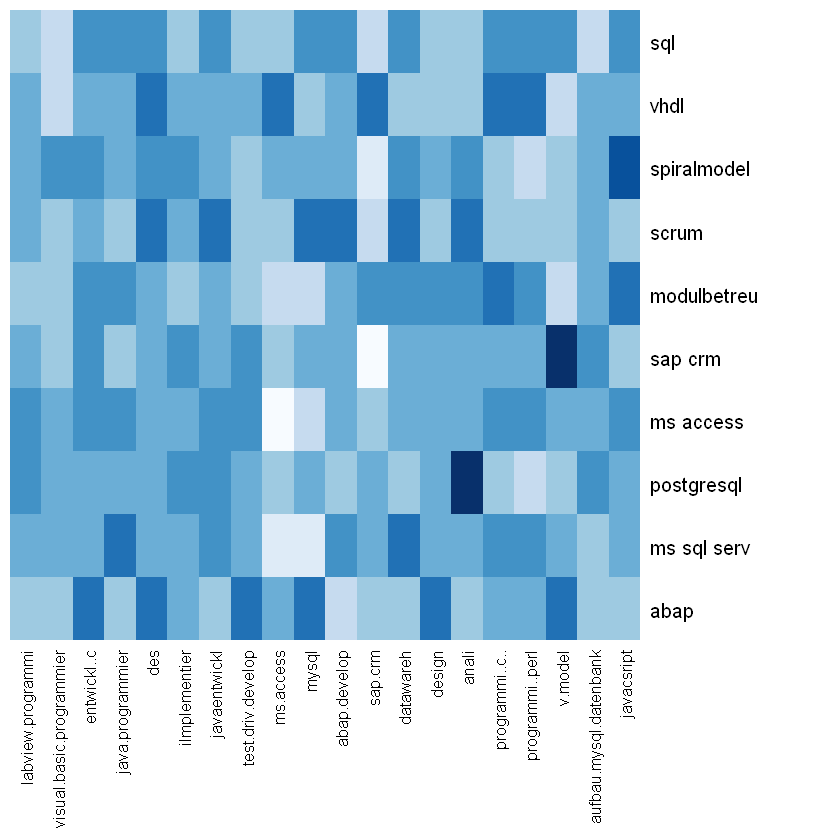

In [62]:
heatmap(as.matrix(similarity_matrix), Rowv=NA, Colv=NA, col=brewer.pal(9,"Blues"), margins =c(10,10))


# Verbesserungsmöglichkeiten
* Evaluation der Ergebnisse durch Test-Daten
* Verbesserung des Matchings durch Kombination von mehreren Ähnlichkeitsfunktionen oder Nutzung von Regeln
* Integration von bestehender Ontologie & Lexikon oder Erstellung
* Einsatz von Machine-Learning-Methoden, z.B. Naive Bayes oder KNN. Nur möglich, wenn Daten von Experten gelabelt werden um als Trainingsdaten genutzt werden zu können
* Mehr Daten
* ...